# Equipe 152
Integrantes:
* Juliana Borsari Jeronimo - Negócios - juju.borsari@gmail.com - 61982235117
* Pedro André Barrozo - Dev - pedroandrebarrozo@gmail.com - 21976758729
* Rafael Mendes Matos - Negócios - rmmatos87@gmail.com - 21999152730
* Ramon Fernandes Viana - Dev - ramon.viana@aluno.ufop.edu.br - 31971870924

# O desafio
O ONS propõe o desafio de estimar a precipitação (quantitativamente) para postos pluviométricos que apresentem dado nulo e/ou dado incorreto. O método deve ser aplicado para uma das duas bacias hidrográficas, Iguaçu ou Paranapanema, localizadas no estado do Paraná, utilizando os dados da rede de estações meteorológicas e de postos pluviométricos para a sua respectiva área de contribuição.

## Mais sobre o desafio
O processo de previsão de vazão realizado diariamente no ONS é composto de diversas fases, sendo uma delas a consistência dos dados de precipitação observados nas bacias hidrográfica de interesse do Sistema Interligado Nacional (SIN). A variabilidade espaço-temporal da precipitação, a baixa densidade de estações meteorológicas e postos pluviométricos e os problemas operacionais destas redes são fatores de complexidade para o modelo chuva-vazão. Os dois primeiros podem ser resolvidos pelo uso de estimativas de precipitação por satélite e radar. Quanto aos problemas operacionais, alguns são identificados por meio de técnicas de controle de qualidade (valores extremos, impossíveis e “outliers”). No entanto, a ausência do dado e/ou dado com valor possível, mas incorreto quando comparado com os postos vizinhos é crítica. O ONS recebe diariamente dados de precipitação da rede meteorológica nacional e da rede de postos pluviométricos dos agentes de geração. Estes dados possuem frequência horária e diária. No caso dos dados diários a precipitação é totalizada as 7h ou 9h local, que corresponde respectivamente as 10 UTC e 12 UTC. Os dados nulos e/ou incorretos são estimados pelo meteorologista.

Links recomendados e vídeos explicativos:
* [ANA - Portal Hidroweb](https://www.snirh.gov.br/hidroweb/mapa)
* [Dados Históricos - Instituto Meteorológico](https://portal.inmet.gov.br/dadoshistoricos)
* [Mapa - Instituto Meteorológico](https://mapas.inmet.gov.br/)
* [Relatório de Alturas Diárias de Precipitação - Instituto de Águas do Paraná](http://www.sih-web.aguasparana.pr.gov.br/sih-web/gerarRelatorioAlturasDiariasPrecipitacao.do?action=carregarInterfaceInicial)


In [10]:
from getpass import getpass
from requests.structures import CaseInsensitiveDict
from zipfile import ZipFile

import json
import numpy as np
import os
import pandas as pd
import requests

os.mkdir('Resultado') # pasta de resultados obtidos
os.mkdir('BD') # pasta de banco de dados

def baixa_csv(link, nome):
    csv = pd.read_csv(link, sep=";", decimal=",")
    csv.to_csv(f"{nome}.csv")
    return csv

# Coleta de Dados Oficiais
Foram utilizadas as bases de dados oficiais para delimitar as bacias especificadas: *Iguaçu* e *Paranapanema*.

A base utilizada foi [Contorno de Bacia Hidroenergética](https://dados.ons.org.br/dataset/bacia_contorno), cujos dados seguem o formato:

|Descrição|Formato em Json|Tipo de Dado|Formato|
|-|-|-|-|
|Conjunto de Dados da Bacia Hidro Energética|type|TEXTO|Sem tamanho fixo|
|Nome da Bacia Hidro Energética|Properties / Nome_Bacia|TEXTO|Sem tamanho fixo|
|Identificador da Bacia Hidro Energética.<br>Algumas bacias não têm este identificador.<br><br>Algumas Bacias não tem esta informação<br>e não são representadas no arquivo.|Properties / Bacia_ID|TEXTO|Sem tamanho fixo|
|Tipo de vetorização da Bacia Hidro Energética|Geometry / type|TEXTO|Sem tamanho fixo|
|Longitude do conjunto N, onde N é um número<br>sequência que representa o par de<br>coordenadas, expressas em graus.|Geometry / coordinates/ 0 / N / 0|FLOAT|Sem tamanho fixo|
|Latitude do conjunto N, onde N é um número<br>sequência que representa o par de<br>coordenadas, expressas em graus.|Geometry / coordinates/ 0 / N / 1|FLOAT|Sem tamanho fixo|

Para melhor visualização desses dados, serão criadas tabelas com duas colunas, uma de Longitude e outra de Latitude e o índice será o número do ponto.

In [11]:
def organiza_df(csv, nome):
    df = pd.DataFrame()
    lon = [i for i in csv.columns if i.endswith('0')]
    lat = [i for i in csv.columns if i.endswith('1')]
    df['Longitude'] = csv.loc[:, lon].T.values[:, 0]
    df['Latitude'] = csv.loc[:, lat].T.values[:, 0]
    df = df.apply(pd.to_numeric, errors="coerce")
    df.to_excel(f"BD/{nome}.xlsx")
    df.to_csv(f"BD/{nome}.csv")
    return df

url_paranapanema = ("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/" +
                    "bacia_contorno/paranapanema.csv")
url_iguacu = ("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/" +
              "bacia_contorno/iguacu.csv")

df_cont_paranapanema = organiza_df(
    pd.read_csv(url_paranapanema, sep=';', decimal='.'),
    'contorno_paranapanema'
    )

df_cont_iguacu = organiza_df(
    pd.read_csv(url_iguacu, sep=';', decimal='.'),
    'contorno_iguacu'
    )


Para encontrar a posição geográfica das estações utilizou a base de dados [Precipitação Diária Observada](https://dados.ons.org.br/dataset/precipitacao-estacao/resource/838def1a-48f5-40b1-9485-d5bbbfc728ec).

Na verdade trabalhamos com os dados das planilha que foram disponibilizada inicialmente em https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/precipitacao_estacao_di/DadosPrecipitacao202110.zip, porém este link foi retirado do ar para utilizar o link do arquivo csv abaixo.

In [12]:
link_precipitacao_diaria = 'https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/precipitacao_estacao_di/Precipitacao_Diaria_Observada-2021.csv'

In [13]:
csv_estacoes = pd.read_csv(link_precipitacao_diaria,
                           sep=";",
                           decimal=".",
                           index_col=0).iloc[:, :2]
csv_estacoes.columns = ['Latitude', 'Longitude']
csv_estacoes = csv_estacoes.loc[:, ['Longitude', 'Latitude']]
csv_estacoes = csv_estacoes.reset_index().drop_duplicates(
    subset='cod_estacao',
    keep='first').set_index('cod_estacao')
csv_estacoes.to_csv('BD/estacoes.csv')

## 1º Entregável
Visualização espacial dos contornos das bacias com os pontos de estações de medição.

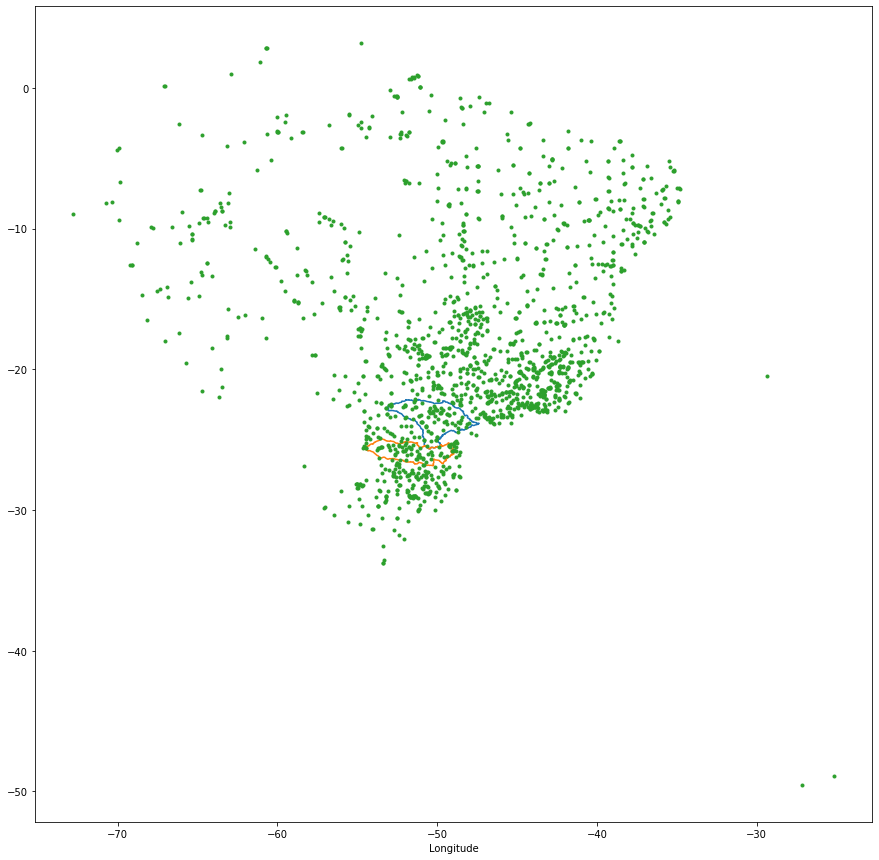

In [14]:
ax = df_cont_paranapanema.plot(figsize=(15, 15),
                               x="Longitude",
                               y="Latitude",
                               legend=False);
df_cont_iguacu.plot(ax=ax, x="Longitude", y="Latitude", legend=False);

csv_estacoes.plot(x="Longitude", y="Latitude", legend=False, ax=ax, style='.');

Decidimos encontrar quais sensores estão dentro da bacia utilizando a biblioteca **shapely** do Python:

In [15]:
from shapely.geometry import Point, Polygon
iguacu = Polygon(df_cont_iguacu.values)

interno_i = []
externo_i = []

for cod, x, y in csv_estacoes.reset_index().values:
    p = Point(x, y)
    if iguacu.contains(p):
        interno_i.append((cod, x, y))
    else:
        externo_i.append((cod, x, y))

len(interno_i), len(externo_i)

(61, 1597)

In [16]:
paranapanema = Polygon(df_cont_paranapanema.values)

interno_p = []
externo_p = []

for cod, x, y in csv_estacoes.reset_index().values:
    p = Point(x, y)
    if paranapanema.contains(p):
        interno_p.append((cod, x, y))
    else:
        externo_p.append((cod, x, y))

len(interno_p), len(externo_p)

(72, 1586)

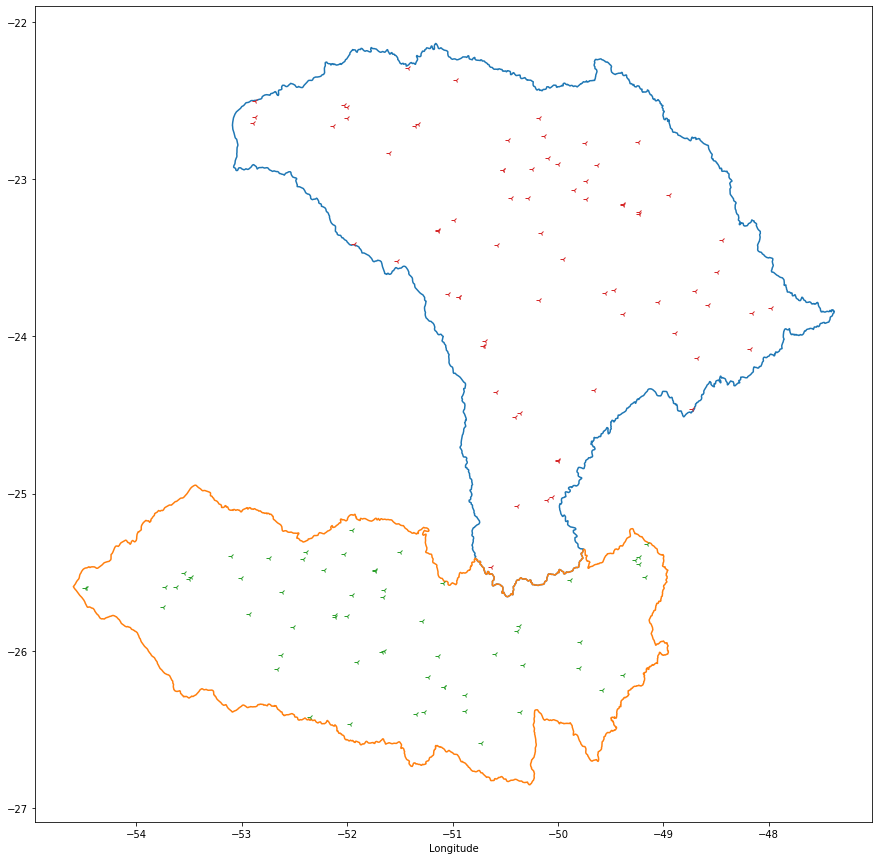

In [17]:
ax1 = df_cont_paranapanema.plot(figsize=(15, 15), x="Longitude", y="Latitude", legend=False);
df_cont_iguacu.plot(ax=ax1, x="Longitude", y="Latitude", legend=False);
estacoes_iguacu = pd.DataFrame(interno_i, columns=['COD', 'Longitude', 'Latitude'])
estacoes_iguacu.plot(x='Longitude', y='Latitude', legend=False, ax=ax1, style='3');
estacoes_paranapanema = pd.DataFrame(interno_p, columns=['COD', 'Longitude', 'Latitude'])
estacoes_paranapanema.plot(x='Longitude', y='Latitude', legend=False, ax=ax1, style='3');

In [18]:
print('Portanto dentro da bacia de Paranapanema encontramos os sensores:')
print(*[i[0] for i in interno_p], sep=', ')
print('Dentre os quais foram verificados os sensores automáticos:')
print(*[i for i, _, _ in interno_p if i.startswith('A') or i.startswith('B')], sep=', ')

Portanto dentro da bacia de Paranapanema encontramos os sensores:
02448071, 02348090, 02449067, 02347192, 02348086, 02348034, 02250090, 02250091, 02448072, 02448073, 02349042, 02349074, 02349076, 02348092, 02252050, 02349068, 02350000, 02349041, 02349023, 02349077, 02350001, 02252051, 02250089, 02249110, 02252049, 83766, 83768, 83836, 02251070, 02350002, 02249109, 02450061, 83813, 02450003, 02450073, 02450072, 02550016, 02450075, 02350015, 02350016, 02351079, 02351080, 02550072, 02550080, 02349078, 02349081, PSATCNI, PSATCPV, PSATCHT, PSATJUR, PSATMAU, PSATROS, A714, A715, A718, A725, A819, A821, A835, A849, A850, A871, A842, 02250097, 02250098, 02250099, 02250100, 02252053, 02350075, 02251080, 02251081, 02249113
Dentre os quais foram verificados os sensores automáticos:
A714, A715, A718, A725, A819, A821, A835, A849, A850, A871, A842


In [19]:
print('Portanto dentro da bacia de Iguaçu encontramos os sensores:')
print(*[i[0] for i in interno_i], sep=', ')
print('Dentre os quais foram verificados os sensores automáticos:')
print(*[i for i, _, _ in interno_i if i.startswith('A') or i.startswith('B')], sep=', ')

Portanto dentro da bacia de Iguaçu encontramos os sensores:
83011, 02553068, 02552009, 02651043, 02652035, 02549105, 02549106, 02550069, 02551054, 02552056, 02553062, 02650027, 02650030, 02651054, 02651056, 02651057, 02651058, 02651059, 83842, 02552055, 02651055, 02652048, 02650028, 83827, 83840, 02552030, 02551063, 02649073, 02649074, 02551073, 02551074, 02552057, 02552062, 02552073, 02650026, 02650029, 02551069, 02551015, PSATFZA, PSATJSG, PSATSCX, PSATSCL, PSATUVT, A807, A823, A855, A862, A874, A876, B804, B806, A875, 02551059, 02553071, 02553072, 02553073, 02552070, 02553079, 02552069, A864, A846
Dentre os quais foram verificados os sensores automáticos:
A807, A823, A855, A862, A874, A876, B804, B806, A875, A864, A846


**Nota:**
No arquivo que trabalhamos inicialmente, somente foram encontrados os sensores:
* Paranapanema: A714, A725, A821, A835
* Iguaçu: A807, A823, A862, A864, A876, B806

In [20]:
paranapanema = ['A714', 'A725', 'A821','A835']
iguacu = ['A807', 'A823', 'A862','A864', 'A876', 'B806']

# Dados dos sensores
Entendemos que os dados mais importantes, dados dos sensores, seriam conseguidos através da API do [SINtegre](https://sintegre.ons.org.br/), porém, diferente das expectativas, o sistema não respondeu às diversas tentativas de requisições realizadas. Dessa forma, o tempo gasto tentando-se alcançar estes dados foi um desperdício.

# Coleta de dados do INMET
Apesar do ONS ter disponibilizado os dados das estações meteorológicas de 1 ano e 10 meses, achamos interessante utilizar a base de dados do INMET pois:
* verificamos inconsistências entre os dados originais (INMET) e os dados disponibilizados (Portal de dados abertos do ONS);
* Os dados disponibilzados pelo ONS são consolidados, o que remove a característica de dados faltantes e insere erro humano nas medições.

Base utilizada: [Dados Históricos Anuais - INMET](https://portal.inmet.gov.br/dadoshistoricos).

In [21]:
def get_dados_historicos(ano: str):
    url_estacoes = f"https://portal.inmet.gov.br/uploads/dadoshistoricos/{ano}.zip"
    with open(f'{ano}.zip', 'wb') as zf:
        zf.write(requests.get(url_estacoes).content)
get_dados_historicos(2019)
get_dados_historicos(2020)
get_dados_historicos(2021)

Removendo o zip:

In [22]:
!unzip '2019.zip' -d 'BD/'
!unzip '2020.zip' -d 'BD/2020/'
!unzip '2021.zip' -d 'BD/2021/'

Archive:  2019.zip
   creating: BD/2019/
  inflating: BD/2019/INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_DF_A042_BRAZLANDIA_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_GO_A002_GOIANIA_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_GO_A003_MORRINHOS_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_GO_A005_PORANGATU_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_GO_A011_SAO SIMAO_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_GO_A012_LUZIANIA_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_GO_A013_ARAGARCAS_01-01-2019_A_31-12-2019.CSV  
  inflating: BD/2019/INMET_CO_GO_A014_GOIAS_01-01-2019_A_31-12-2019.CSV  
  infla

Analisando os dados do ano 2020

In [23]:
ano = 2020

nomes = os.listdir(f'BD/{ano}/')

df_aux = pd.DataFrame(index= pd.date_range(f'{ano}0101', f'{ano}1231 23:00', freq = 'H'))

for i, nome in enumerate(nomes):
  
    df = pd.read_csv(f'BD/{ano}/' + nome, 
                     sep=';',
                     encoding='latin-1',
                     error_bad_lines=False, 
                     skiprows=7,
                     decimal=',',
                     header=1,
                     usecols=range(3))
  
    tag = pd.read_csv(f'BD/{ano}/' + nome, 
                      sep=';',
                      encoding='latin-1',
                      error_bad_lines=False, 
                      decimal=',',
                      nrows = 3).iloc[2,1]

    # Eliminando sensores com menos de 6000 leituras
    # if df.iloc[:,2].isna().sum() >= 6000:
    #     print('Pulando', tag)
    #     continue
    print(i, 'de', len(nomes)-1)
    df_aux[tag] = pd.DataFrame(
        df.iloc[:,2].values,
        index=pd.date_range('%s %s:00' % (df.iloc[0,0], df.iloc[0,1][:2]),
                            '%s %s:00'%(df.iloc[-1,0], df.iloc[-1,1][:2]),
                            freq='H')
    )

df_aux.to_csv(f'Resultado/precipitacoes_horarias_full_{ano}.csv')

0 de 588
1 de 588
2 de 588
3 de 588
4 de 588
5 de 588
6 de 588
7 de 588
8 de 588
9 de 588
10 de 588
11 de 588
12 de 588
13 de 588
14 de 588
15 de 588
16 de 588
17 de 588
18 de 588
19 de 588
20 de 588
21 de 588
22 de 588
23 de 588
24 de 588
25 de 588
26 de 588
27 de 588
28 de 588
29 de 588
30 de 588
31 de 588
32 de 588
33 de 588
34 de 588
35 de 588
36 de 588
37 de 588
38 de 588
39 de 588
40 de 588
41 de 588
42 de 588
43 de 588
44 de 588
45 de 588
46 de 588
47 de 588
48 de 588
49 de 588
50 de 588
51 de 588
52 de 588
53 de 588
54 de 588
55 de 588
56 de 588
57 de 588
58 de 588
59 de 588
60 de 588
61 de 588
62 de 588
63 de 588
64 de 588
65 de 588
66 de 588
67 de 588
68 de 588
69 de 588
70 de 588
71 de 588
72 de 588
73 de 588
74 de 588
75 de 588
76 de 588
77 de 588
78 de 588
79 de 588
80 de 588
81 de 588
82 de 588
83 de 588
84 de 588
85 de 588
86 de 588
87 de 588
88 de 588
89 de 588
90 de 588
91 de 588
92 de 588
93 de 588
94 de 588
95 de 588
96 de 588
97 de 588
98 de 588
99 de 588
100 de 588

# 2º Entregável
Calculando as correlações entre os dados de precipitações para verificar quais sensores serão utilizados no modelo.

In [24]:
corr_p = set()
for t in paranapanema:
    for i in df_aux.corr().loc[df_aux.corr()[t].abs()>=0.1,[t]].index:
        corr_p.add(i)

corr_i = set()
for t in iguacu:
    for i in df_aux.corr().loc[df_aux.corr()[t].abs()>=0.1,[t]].index:
        corr_i.add(i)

with open('Resultado/lista_correlacao_parapanema.csv', 'w') as f:
    f.write(','.join(corr_p))

with open('Resultado/lista_correlacao_iguacu.csv', 'w') as f:
    f.write(','.join(corr_i))

In [25]:
print('Foram encontradas %d estações com precipitação correlata com a bacia de Paranapanema e %d com a bacia de Iguaçu' %
      (len(corr_p), len(corr_i)))

Foram encontradas 46 estações com precipitação correlata com a bacia de Paranapanema e 72 com a bacia de Iguaçu


## Analisando quantidade de dados nulos

In [26]:
print(df_aux.loc[:,paranapanema].info())
print(df_aux.loc[:,iguacu].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: H
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A714    7177 non-null   float64
 1   A725    124 non-null    float64
 2   A821    7296 non-null   float64
 3   A835    7319 non-null   float64
dtypes: float64(4)
memory usage: 343.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A807    8565 non-null   float64
 1   A823    8784 non-null   float64
 2   A862    8784 non-null   float64
 3   A864    2184 non-null   float64
 4   A876    7791 non-null   float64
 5   B806    8337 non-null   float64
dtypes: float64(6)
memory usage: 480.4 KB
None


Ao analisar a quantidade de dados não nulos, percebemos que existem sensores com pouquíssimos dados não nulos, como o *A725* e o *A864*.

## Testando os dados de 2019

In [27]:
ano = 2019

nomes = os.listdir(f'BD/{ano}/')

df_aux = pd.DataFrame(index= pd.date_range(f'{ano}0101', f'{ano}1231 23:00', freq = 'H'))

for i, nome in enumerate(nomes):
  
    df = pd.read_csv(f'BD/{ano}/' + nome, 
                     sep=';',
                     encoding='latin-1',
                     error_bad_lines=False, 
                     skiprows=7,
                     decimal=',',
                     header=1,
                     usecols=range(3))
  
    tag = pd.read_csv(f'BD/{ano}/' + nome, 
                      sep=';',
                      encoding='latin-1',
                      error_bad_lines=False, 
                      decimal=',',
                      nrows = 3).iloc[2,1]

    # Eliminando sensores com menos de 6000 leituras
    if df.iloc[:,2].isna().sum() >= 6000:
        print('Pulando', tag)
        continue
    print(i, 'de', len(nomes)-1)
    df_aux[tag] = pd.DataFrame(
        df.iloc[:,2].values,
        index=pd.date_range('%s %s:00' % (df.iloc[0,0], df.iloc[0,1][:2]),
                            '%s %s:00'%(df.iloc[-1,0], df.iloc[-1,1][:2]),
                            freq='H')
    )

df_aux.to_csv(f'Resultado/precipitacoes_horarias_full_{ano}.csv')

0 de 588
1 de 588
2 de 588
3 de 588
4 de 588
Pulando A720
6 de 588
Pulando A353
8 de 588
9 de 588
10 de 588
11 de 588
12 de 588
13 de 588
14 de 588
15 de 588
16 de 588
17 de 588
18 de 588
19 de 588
20 de 588
21 de 588
22 de 588
23 de 588
24 de 588
25 de 588
26 de 588
27 de 588
28 de 588
29 de 588
30 de 588
31 de 588
32 de 588
33 de 588
34 de 588
35 de 588
36 de 588
37 de 588
38 de 588
39 de 588
40 de 588
41 de 588
42 de 588
43 de 588
44 de 588
45 de 588
46 de 588
47 de 588
48 de 588
49 de 588
50 de 588
51 de 588
52 de 588
53 de 588
54 de 588
55 de 588
56 de 588
57 de 588
58 de 588
59 de 588
60 de 588
61 de 588
62 de 588
63 de 588
64 de 588
65 de 588
66 de 588
67 de 588
68 de 588
69 de 588
70 de 588
71 de 588
72 de 588
73 de 588
74 de 588
75 de 588
76 de 588
77 de 588
78 de 588
79 de 588
80 de 588
81 de 588
82 de 588
83 de 588
84 de 588
85 de 588
86 de 588
87 de 588
88 de 588
89 de 588
90 de 588
91 de 588
92 de 588
93 de 588
94 de 588
95 de 588
96 de 588
97 de 588
98 de 588
99 de 588
10

In [28]:
print(df_aux[paranapanema].info())
print(df_aux[iguacu].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2019-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A714    8760 non-null   float64
 1   A725    7934 non-null   float64
 2   A821    8267 non-null   float64
 3   A835    7369 non-null   float64
dtypes: float64(4)
memory usage: 342.2 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2019-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A807    8587 non-null   float64
 1   A823    8377 non-null   float64
 2   A862    7547 non-null   float64
 3   A864    8626 non-null   float64
 4   A876    8760 non-null   float64
 5   B806    8529 non-null   float64
dtypes: float64(6)
memory usage: 479.1 KB
None


Os dados estão muito mais completos. Será usado a base de dados de 2019.
## Refazendo as correlações

In [29]:
corr_p = set()
for t in paranapanema:
    for i in df_aux.corr().loc[df_aux.corr()[t].abs()>=0.1,[t]].index:
        corr_p.add(i)

corr_i = set()
for t in iguacu:
    for i in df_aux.corr().loc[df_aux.corr()[t].abs()>=0.1,[t]].index:
        corr_i.add(i)

with open('Resultado/lista_correlacao_parapanema.csv', 'w') as f:
    f.write(','.join(corr_p))

with open('Resultado/lista_correlacao_iguacu.csv', 'w') as f:
    f.write(','.join(corr_i))

In [30]:
print('Foram encontradas %d estações com precipitação correlata com a bacia de Paranapanema e %d com a bacia de Iguaçu' %
      (len(corr_p), len(corr_i)))

Foram encontradas 28 estações com precipitação correlata com a bacia de Paranapanema e 52 com a bacia de Iguaçu


# 3º Entregável
## Verificando features correlatos

In [31]:
nome = [i for i in os.listdir(f'BD/{ano}/') if paranapanema[0] in i]

df = pd.read_csv(f'BD/{ano}/' + nome[0],
                 sep=';',
                 encoding='latin-1',
                 error_bad_lines=False, 
                 skiprows=7,
                 decimal=',',
                 header=1,
                 )
df.corr()

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",1.000000,-0.085518,-0.076568,-0.093803,-0.104665,-0.038679,0.088399,-0.009777,-0.035463,0.091248,0.082372,0.129450,0.094982,0.135039,-0.024868,0.112148,0.021075,NaN
"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",-0.085518,1.000000,0.996160,0.996392,0.049531,-0.462531,-0.515047,-0.464683,-0.495894,-0.528470,-0.495821,0.072234,0.076914,0.055850,0.229740,0.097711,0.204787,NaN
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),-0.076568,0.996160,1.000000,0.996401,0.104004,-0.442181,-0.516710,-0.445393,-0.477583,-0.525383,-0.499028,0.052057,0.056840,0.033573,0.214927,0.110802,0.208868,NaN
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),-0.093803,0.996392,0.996401,1.000000,0.094534,-0.445949,-0.518825,-0.449904,-0.480051,-0.529350,-0.500035,0.052292,0.059427,0.035145,0.217458,0.091096,0.195663,NaN
RADIACAO GLOBAL (KJ/m²),-0.104665,0.049531,0.104004,0.094534,1.000000,0.546428,-0.031528,0.508891,0.453151,0.081762,-0.070155,-0.496847,-0.542421,-0.595521,-0.254085,0.120213,-0.015888,NaN
"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",-0.038679,-0.462531,-0.442181,-0.445949,0.546428,1.000000,0.485261,0.989363,0.986968,0.559526,0.414824,-0.682967,-0.703034,-0.705620,-0.399390,0.059261,-0.103097,NaN
TEMPERATURA DO PONTO DE ORVALHO (°C),0.088399,-0.515047,-0.516710,-0.518825,-0.031528,0.485261,1.000000,0.468806,0.502378,0.985495,0.984894,0.272240,0.225889,0.255286,-0.126499,-0.054426,-0.088464,NaN
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),-0.009777,-0.464683,-0.445393,-0.449904,0.508891,0.989363,0.468806,1.000000,0.984262,0.545390,0.393817,-0.697629,-0.732110,-0.711072,-0.391965,0.089544,-0.080108,NaN
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),-0.035463,-0.495894,-0.477583,-0.480051,0.453151,0.986968,0.502378,0.984262,1.000000,0.569568,0.439449,-0.674970,-0.679278,-0.671754,-0.386389,0.060058,-0.099045,NaN
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),0.091248,-0.528470,-0.525383,-0.529350,0.081762,0.559526,0.985495,0.545390,0.569568,1.000000,0.969736,0.196208,0.140521,0.163210,-0.165970,-0.027038,-0.080282,NaN


Percebe-se que os features:
* PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),
* PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),
* TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),
* TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),
* TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),
* TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),
* UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),
* UMIDADE REL. MIN. NA HORA ANT. (AUT) (%).

In [32]:
nomes = os.listdir(f'BD/{ano}/')

df_aux1 = pd.DataFrame(index=pd.date_range(f'{ano}0101',
                                           f'{ano}1231 23:00',
                                           freq='H'))

for i,nome in enumerate(nomes):
    df = pd.read_csv(f'BD/{ano}/' + nome,
                     sep = ';',
                     encoding='latin-1',
                     error_bad_lines=False,
                     skiprows=7,
                     decimal=',',
                     header=1,
                     usecols=[0,1,3,6,7,8,15,16,18])
    
    tag = pd.read_csv(f'BD/{ano}/' + nome,
                      sep=';',
                      encoding='latin-1',
                      error_bad_lines=False,
                      decimal=',',
                      nrows = 3).iloc[2,1]

    if tag not in corr_i or tag not in corr_p:
        print('Pulando', tag)
        continue
    
    print(i, 'de', len(nomes)-1)

    df_aux1 = df_aux1.join(pd.DataFrame(
        df.iloc[:,2:].values,
        index=pd.date_range('%s %s:00' % (df.iloc[0,0], df.iloc[0,1][:2]),
                            '%s %s:00'%(df.iloc[-1,0], df.iloc[-1,1][:2]),
                            freq='H'),
                            columns = [tag+'_'+i for i in df.columns[2:]])
    )
df_aux1.to_csv(f'Resultado/dados_brutos_demais_variaveis_{ano}.csv')

Pulando A881
Pulando A450
Pulando A016
Pulando A806
Pulando A302
Pulando A720
6 de 588
Pulando A353
Pulando A621
Pulando A054
Pulando A438
Pulando A375
Pulando A418
Pulando A886
Pulando A615
Pulando A133
Pulando A244
Pulando A824
Pulando A407
Pulando A121
Pulando A315
Pulando A424
Pulando A916
Pulando A108
Pulando A537
Pulando A510
Pulando A756
Pulando S715
Pulando A841
Pulando A014
Pulando A719
Pulando A038
Pulando S701
Pulando A425
Pulando A358
Pulando A884
Pulando A602
Pulando A612
Pulando A906
Pulando A124
Pulando A864
Pulando A357
Pulando A857
Pulando A739
Pulando A628
Pulando S716
Pulando A308
Pulando A913
Pulando A853
Pulando A866
Pulando A421
Pulando A365
Pulando A430
Pulando A002
Pulando A910
Pulando A747
Pulando A417
Pulando A009
Pulando A838
Pulando A220
Pulando A224
Pulando A726
Pulando A607
Pulando A240
Pulando A341
Pulando A608
Pulando A423
Pulando A834
Pulando A871
Pulando A613
Pulando A833
Pulando A549
Pulando A546
Pulando A313
Pulando A371
Pulando A859
Pulando A752
Pul

# Juntando os dados em uma só base de dados
De modo que possamos amostrar os dados como um todo, as bases de dados são unidas em só um banco de dados. Escolhendo a bacia de **Paranapanema** para testes. 

In [33]:
df_prec = pd.read_csv('Resultado/precipitacoes_horarias_full_2019.csv',
                      index_col=0,
                      parse_dates=True)
df_outros = pd.read_csv('Resultado/dados_brutos_demais_variaveis_2019.csv',
                        index_col=0,
                        parse_dates=True)

df_total = df_prec.join(df_outros)

# Tratando os dados faltantes com o preenchimento com a mediana
def preenche_mediana(df):
    for coluna in df.columns:
        df[coluna].fillna(df[coluna].median(), inplace=True)
    return df

df_total_preenchido = preenche_mediana(df_total)

df_p = df_total_preenchido.loc[:, paranapanema]

In [34]:
# aproximadamente 80% dos pontos
y_train = df_total_preenchido.loc[:'2019-10-19', paranapanema]
y_test = df_total_preenchido.loc['2019-10-19':, paranapanema]
y_train.shape[0], y_test.shape[0]

(7008, 1776)

In [35]:
X_train = df_total_preenchido.loc[:'2019-10-19', [i for i in corr_p if i not in paranapanema]]
X_test = df_total_preenchido.loc['2019-10-19':, [i for i in corr_p if i not in paranapanema]]
X_train.shape[0], X_test.shape[0]

(7008, 1776)

# Modelo do scikit-learn

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Normalizer

norm_y = Normalizer().fit(y_train)
norm_X = Normalizer().fit(X_train)

y_train_n = norm_y.transform(y_train)
y_test_n = norm_y.transform(y_test)

X_train_n = norm_X.transform(X_train)
X_test_n = norm_X.transform(X_test)

regr = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)
regr.fit(X_train_n, y_train_n)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [38]:
y_pred = regr.predict(X_test_n)

In [39]:
regr.score(X_test_n, y_test_n)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.08593523965679695

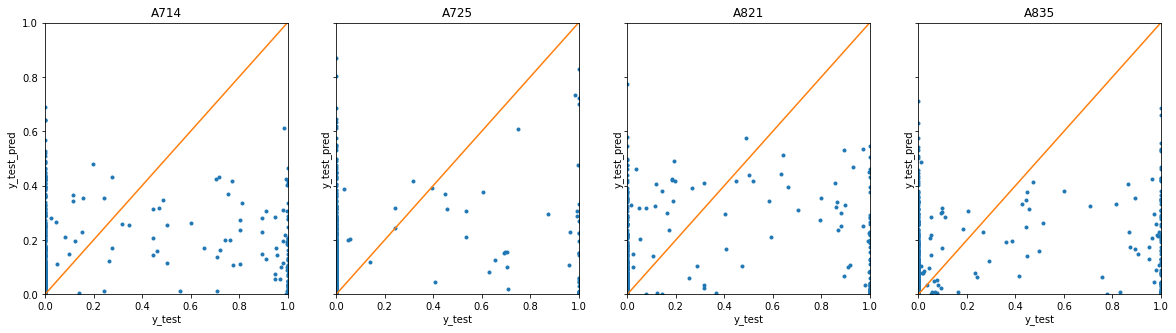

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 5))
for i, nome in enumerate(paranapanema):
    # plotando valores verdadeiros contra predições
    axs.ravel()[i].plot(y_test_n[:, i], y_pred[:, i], '.', label=nome)

    # plotando a reta x=y
    axs.ravel()[i].plot([[0], [1]], [[0], [1]])

    axs.ravel()[i].set_title(nome)

    # legenda dos eixos
    axs.ravel()[i].set_xlabel('y_test')
    axs.ravel()[i].set_ylabel('y_test_pred')

    axs.ravel()[i].set_xlim((0,1))
    axs.ravel()[i].set_ylim((0,1))
    
plt.show()

# Criando dados diários
Como não foi possível fazer um com modelo com os dados horários, possivelmente pela quantidade de zeros, tentaremos agrupar os dados de forma horária.

Para as precipitações, serão tomadas as somas diárias e para os demais dados será calculada a mediana do dia.

In [42]:
n_paranapanema = [i for i in corr_p if i not in paranapanema]

In [43]:
df_prec_d = df_total_preenchido.loc[:, paranapanema].resample('1D').sum()
df_outros_d = df_total_preenchido.loc[:, n_paranapanema].resample('1D').median()

## Modelo com 4 saídas

In [44]:
# aproximadamente 7000 pontos = 80%
y_train = df_prec_d.loc[:'2019-10-19']
y_test = df_prec_d.loc['2019-10-19':]
y_train.shape[0], y_test.shape[0]

(292, 74)

In [45]:
X_train = df_outros_d.loc[:'2019-10-19']
X_test = df_outros_d.loc['2019-10-19':]

X_train.shape[0], X_test.shape[0]

(292, 74)

# Modelo do scikit-learn

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error, r2_score

In [47]:
norm_y = Normalizer().fit(y_train)
norm_X = Normalizer().fit(X_train)

y_train_n = norm_y.transform(y_train)
y_test_n = norm_y.transform(y_test)

X_train_n = norm_X.transform(X_train)
X_test_n = norm_X.transform(X_test)

regr = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)
regr.fit(X_train_n, y_train_n)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [48]:
y_pred = regr.predict(X_test_n)

In [49]:
regr.score(X_test_n, y_test_n)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


-0.08083854118964709

In [50]:
mae = mean_absolute_error(y_test_n, y_pred)
r2 = r2_score(y_test_n, y_pred)

print(f'MAE: {mae}')
print(f'R2: {r2}')

MAE: 0.23147270459370128
R2: -0.09027236759381224


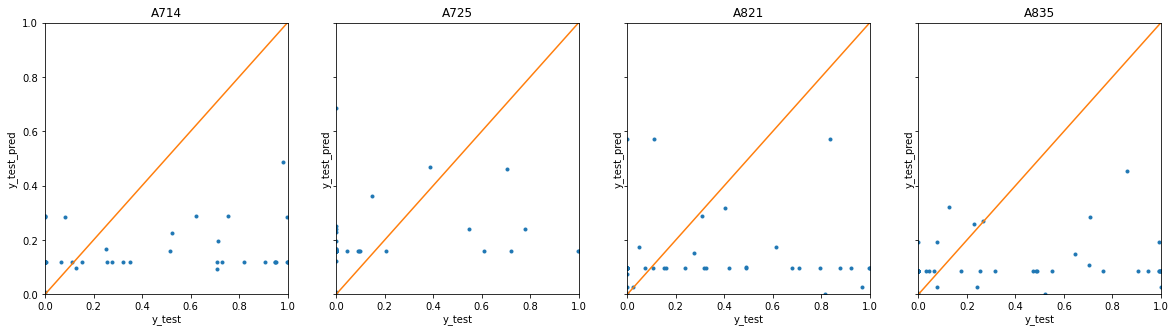

In [51]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 5))
for i, nome in enumerate(paranapanema):
    # plotando valores verdadeiros contra predições
    axs.ravel()[i].plot(y_test_n[:, i], y_pred[:, i], '.', label=nome)

    # plotando a reta x=y
    axs.ravel()[i].plot([[0], [1]], [[0], [1]])

    axs.ravel()[i].set_title(nome)

    # legenda dos eixos
    axs.ravel()[i].set_xlabel('y_test')
    axs.ravel()[i].set_ylabel('y_test_pred')

    axs.ravel()[i].set_xlim((0,1))
    axs.ravel()[i].set_ylim((0,1))
    
plt.show()

## Modelo com remoção de zeros

In [52]:
df_total_d = df_prec_d.join(df_outros_d)
df_total_d.shape

(365, 28)

Testando a quantidade de zeros.

In [57]:
for i in paranapanema:
    print("Existem %d zeros de %d dados na estação %s" %
          (df_total_d.loc[df_total_d[i]!=0].shape[0], len(df_total_d), i))

Existem 123 zeros de 365 dados na estação A714
Existem 113 zeros de 365 dados na estação A725
Existem 110 zeros de 365 dados na estação A821
Existem 96 zeros de 365 dados na estação A835


Removendo uma parte dos zeros da série

(126, 28)

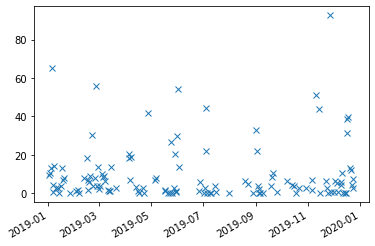

In [58]:
from sklearn.model_selection import train_test_split

mantem_porcentagem = .01

_, df_total_reduzido = train_test_split(df_total_d.loc[df_total_d[paranapanema[0]]==0],
                                  test_size=.01)

df_total_reduzido = df_total_reduzido.append(
    df_total_d.loc[df_total_d[paranapanema[0]]!=0]).sort_index()

# df_total_20[paranapanema[0]].hist(bins=100);
df_total_reduzido[paranapanema[0]].plot(style='x')
df_total_reduzido.shape

In [60]:
# aproximadamente 7000 pontos = 80%
y_train = df_total_reduzido.loc[:'2019-10-19', paranapanema]
y_test = df_total_reduzido.loc['2019-10-19':, paranapanema]
y_train.shape, y_test.shape

((96, 4), (30, 4))

In [62]:
X_train = df_total_reduzido.loc[:'2019-10-19', n_paranapanema]
X_test = df_total_reduzido.loc['2019-10-19':, n_paranapanema]

X_train.shape, X_test.shape

((96, 24), (30, 24))

# Modelo do scikit-learn

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix

In [64]:
norm_y = Normalizer().fit(y_train)
norm_X = Normalizer().fit(X_train)

y_train_n = norm_y.transform(y_train)
y_test_n = norm_y.transform(y_test)

X_train_n = norm_X.transform(X_train)
X_test_n = norm_X.transform(X_test)

regr = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)
regr.fit(X_train_n, y_train_n)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [65]:
y_pred = regr.predict(X_test_n)

In [66]:
regr.score(X_test_n, y_test_n)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


-0.21009351532860251

In [67]:
mae = mean_absolute_error(y_test_n, y_pred)
r2 = r2_score(y_test_n, y_pred)

print(f'MAE: {mae}')
print(f'R2: {r2}')

MAE: 0.2935995640250656
R2: -0.23576739569193103


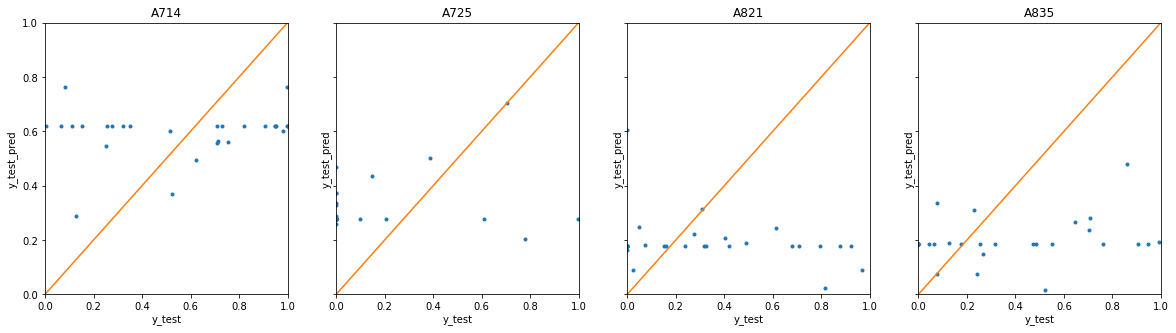

In [68]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 5))
for i, nome in enumerate(paranapanema):
    # plotando valores verdadeiros contra predições
    axs.ravel()[i].plot(y_test_n[:, i], y_pred[:, i], '.', label=nome)

    # plotando a reta x=y
    axs.ravel()[i].plot([[0], [1]], [[0], [1]])

    axs.ravel()[i].set_title(nome)

    # legenda dos eixos
    axs.ravel()[i].set_xlabel('y_test')
    axs.ravel()[i].set_ylabel('y_test_pred')

    axs.ravel()[i].set_xlim((0,1))
    axs.ravel()[i].set_ylim((0,1))
    
plt.show()

# KNN
Testando o regressor de *K Nearest Neighbors*

In [69]:
from sklearn.neighbors import KNeighborsRegressor

n = 5

knn = KNeighborsRegressor(n_neighbors=n)
knn.fit(X_train_n, y_train_n)
y_pred = knn.predict(X_test)

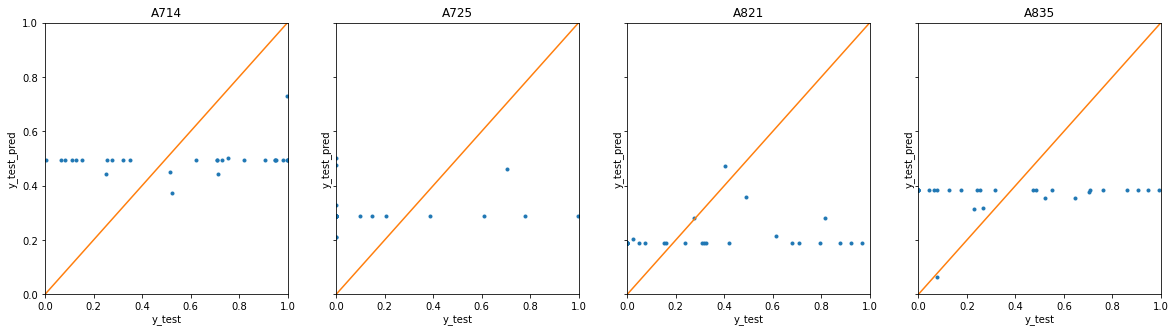

In [70]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 5))
for i, nome in enumerate(paranapanema):
    # plotando valores verdadeiros contra predições
    axs.ravel()[i].plot(y_test_n[:, i], y_pred[:, i], '.', label=nome)

    # plotando a reta x=y
    axs.ravel()[i].plot([[0], [1]], [[0], [1]])

    axs.ravel()[i].set_title(nome)

    # legenda dos eixos
    axs.ravel()[i].set_xlabel('y_test')
    axs.ravel()[i].set_ylabel('y_test_pred')

    axs.ravel()[i].set_xlim((0,1))
    axs.ravel()[i].set_ylim((0,1))
    
plt.show()

# Conclusão
Infelizmente com o gasto de tempo para coletar os dados corretos e tratá-los, sobrou muito pouco tempo para fazer os testes com os modelos. Porém, chegou-se a algumas ideias que podem ser interessantes para ajudar nos futuros modelos.
Portanto, nossos modelos demonstraram nenhuma eficiência para prever os dados dos sensores testados, sendo também outra dificuldade que tentamos vencer foi o excesso de zeros.